In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [ ]:
class MiniAlphaGenome(nn.Module):
    def __init__(self, seq_len=5000, embed_dim=16, conv_channels=32,
                 num_transformer_layers=2, num_cell_types=3):
        super().__init__()

        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.num_cell_types = num_cell_types

        # DNA TOKEN EMBEDDING
        self.embedding = nn.Embedding(4, embed_dim)

        # CELL-TYPE EMBEDDING
        self.celltype_embed_dim = 16
        self.celltype_embedding = nn.Embedding(num_cell_types, self.celltype_embed_dim)

        # Combined embedding dimension
        total_in_channels = embed_dim + self.celltype_embed_dim

        # CNN ENCODER
        self.encoder = nn.Sequential(
            nn.Conv1d(total_in_channels, conv_channels, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(conv_channels, conv_channels, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        # After pooling: 5000 → 2500 → 1250
        self.reduced_len = seq_len // 4

        # TRANSFORMER BACKBONE
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=conv_channels, nhead=4, batch_first=True
            ),
            num_layers=num_transformer_layers
        )

        # DECODER (ConvTranspose)
        self.decoder = nn.ConvTranspose1d(
            conv_channels, conv_channels, kernel_size=4, stride=4
        )

        # THREE PREDICTION HEADS
        self.chrom_head = nn.Conv1d(conv_channels, 1, kernel_size=1)
        self.splice_head = nn.Conv1d(conv_channels, 2, kernel_size=1)
        self.expr_pool = nn.AdaptiveAvgPool1d(78)
        self.expr_head = nn.Conv1d(conv_channels, 1, kernel_size=1)

    # FORWARD: NOW ACCEPTS cell_type INDEX
    def forward(self, x, cell_type):
        # x: (B, L)
        B = x.shape[0]

        # DNA embedding
        x = self.embedding(x)  # (B, L, embed_dim)
        x = x.permute(0, 2, 1)  # (B, embed_dim, L)

        # Add cell-type embedding
        ct = self.celltype_embedding(cell_type)  # (B, ct_dim)
        ct = ct.unsqueeze(-1).repeat(1, 1, self.seq_len)  # (B, ct_dim, L)

        # Concatenate along channel axis
        x = torch.cat([x, ct], dim=1)  # (B, embed_dim+ct_dim, L)

        # NN encoder
        x = self.encoder(x)  # (B, 32, 1250)

        # Transformer
        x_t = x.permute(0, 2, 1)  # (B, 1250, 32)
        x_t = self.transformer(x_t)
        x = x_t.permute(0, 2, 1)

        # Decoder
        x = self.decoder(x)  # (B, 32, 5000)

        # HEADS
        chrom_pred = self.chrom_head(x)               # (B, 1, 5000)
        splice_pred = self.splice_head(x)             # (B, 2, 5000)
        expr_pred = self.expr_head(x)                 # (B, 1, 5000)
        expr_pred = self.expr_pool(expr_pred).squeeze(1)  # (B, 78)

        return chrom_pred, splice_pred, expr_pred


In [ ]:
def generate_synthetic_sample(seq_len=5000):

    dna = torch.randint(0, 4, (1, seq_len), device=device)

    base_chrom = torch.randn(1, 1, seq_len, device=device) * 0.1
    base_expr = torch.randn(1, 78, device=device) * 0.1

    # Pick a cell type
    cell_type = random.randint(0, 2)

    # Cell-type-specific expression scaling
    expr_bias = {
        0: 1.0,
        1: 0.5,
        2: 2.0
    }[cell_type]

    expression = base_expr * expr_bias
    chromatin = base_chrom * (1 + 0.3 * cell_type)

    # Synthetic splicing profile
    splicing = torch.zeros(1, 2, seq_len, device=device)
    for _ in range(20):
        pos = random.randint(100, seq_len - 100)
        splicing[0, 0, pos] = 1.0
        splicing[0, 1, pos + random.randint(-2, 2)] = 1.0

    return dna.squeeze(0), chromatin.squeeze(0), splicing.squeeze(0), expression.squeeze(0), cell_type


In [ ]:
def multitask_loss(p_ch, p_sp, p_ex, t_ch, t_sp, t_ex):

    chrom_loss = F.mse_loss(p_ch, t_ch.unsqueeze(0))
    splice_loss = F.binary_cross_entropy_with_logits(p_sp, t_sp.unsqueeze(0))
    expr_loss = F.mse_loss(p_ex, t_ex.unsqueeze(0))

    return chrom_loss + splice_loss + expr_loss, chrom_loss, splice_loss, expr_loss


In [ ]:
model = MiniAlphaGenome().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    losses = []

    for step in range(20):
        dna, chrom, splicing, expr, ct = generate_synthetic_sample()
        ct_tensor = torch.tensor([ct], device=device)

        optimizer.zero_grad()

        p_ch, p_sp, p_ex = model(dna.unsqueeze(0), ct_tensor)

        loss, lc, ls, le = multitask_loss(p_ch, p_sp, p_ex, chrom, splicing, expr)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss = {np.mean(losses):.4f}")


Epoch 1/3 | Loss = 0.7204
Epoch 2/3 | Loss = 0.6297
Epoch 3/3 | Loss = 0.5967


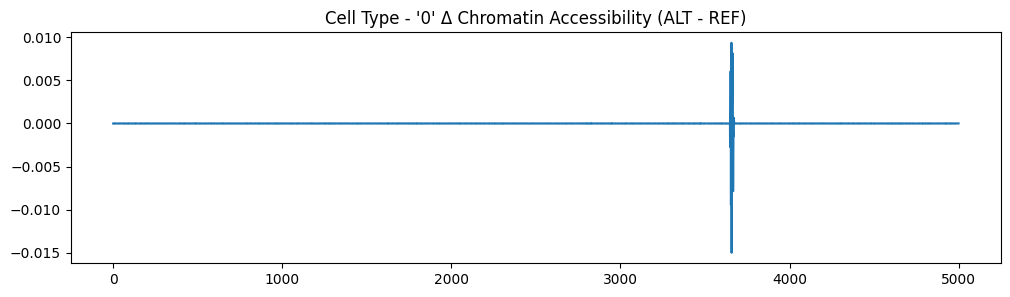

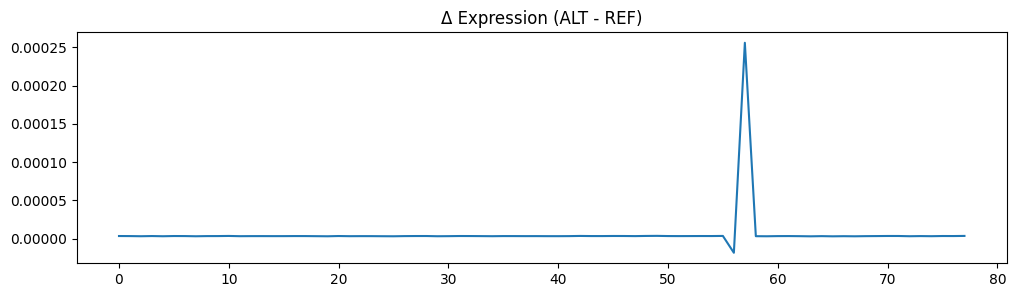

In [ ]:
github.comodel.eval()

# Generate a random DNA sequence
seq_len = 5000
dna = torch.randint(0, 4, (1, seq_len), device=device)

# Make a REF copy and an ALT copy
ref = dna.clone()
alt = dna.clone()

# Introduce a point mutation
pos = random.randint(500, seq_len-500)
ref_base = ref[0, pos].item()
alt_base = random.choice([b for b in [0,1,2,3] if b != ref_base])
alt[0, pos] = alt_base

cell_type = torch.tensor([0], device=device)

# REF vs ALT forward passes
with torch.no_grad():
    ref_ch, ref_sp, ref_ex = model(ref, cell_type)
    alt_ch, alt_sp, alt_ex = model(alt, cell_type)

# Compute Δ = ALT – REF
Δ_ch = (alt_ch - ref_ch).cpu().numpy().flatten()
Δ_ex = (alt_ex - ref_ex).cpu().numpy().flatten()


plt.figure(figsize=(12, 3))
plt.plot(Δ_ch)
plt.title("Cell Type - '0' Δ Chromatin Accessibility (ALT - REF)")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(Δ_ex)
plt.title("Δ Expression (ALT - REF)")
plt.show()


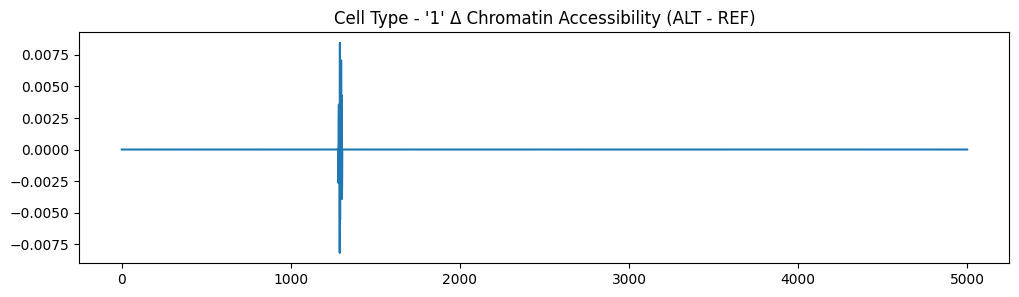

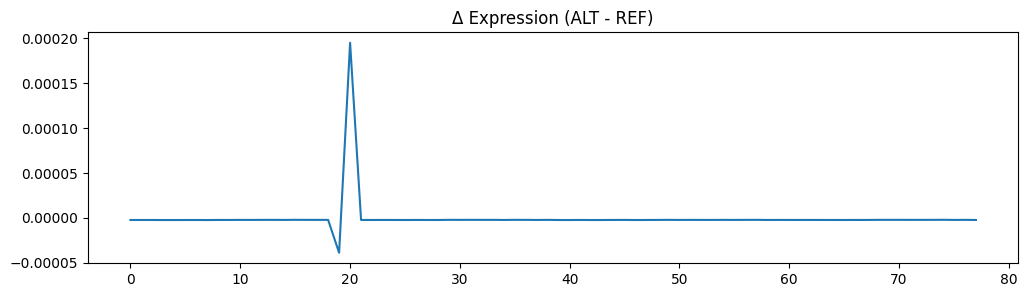

In [ ]:
model.eval()

# Generate a random DNA sequence
seq_len = 5000
dna = torch.randint(0, 4, (1, seq_len), device=device)

# Make a REF copy and an ALT copy
ref = dna.clone()
alt = dna.clone()

# Introduce a point mutation
pos = random.randint(500, seq_len-500)
ref_base = ref[0, pos].item()
alt_base = random.choice([b for b in [0,1,2,3] if b != ref_base])
alt[0, pos] = alt_base

cell_type = torch.tensor([1], device=device)

# REF vs ALT forward passes
with torch.no_grad():
    ref_ch, ref_sp, ref_ex = model(ref, cell_type)
    alt_ch, alt_sp, alt_ex = model(alt, cell_type)

# Compute Δ = ALT – REF
Δ_ch = (alt_ch - ref_ch).cpu().numpy().flatten()
Δ_ex = (alt_ex - ref_ex).cpu().numpy().flatten()

plt.figure(figsize=(12, 3))
plt.plot(Δ_ch)
plt.title("Cell Type - '1' Δ Chromatin Accessibility (ALT - REF)")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(Δ_ex)
plt.title("Δ Expression (ALT - REF)")
plt.show()


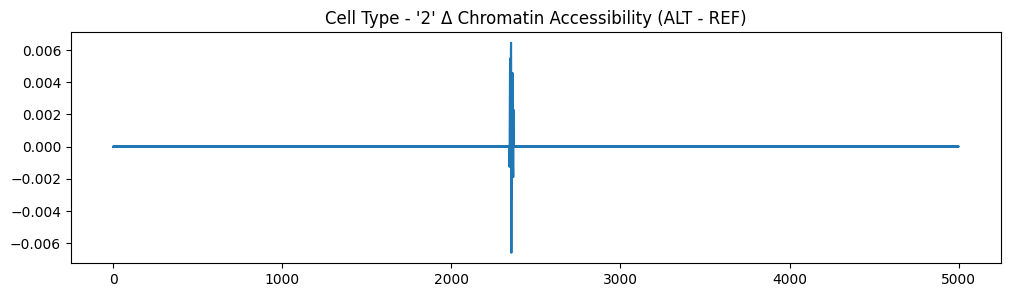

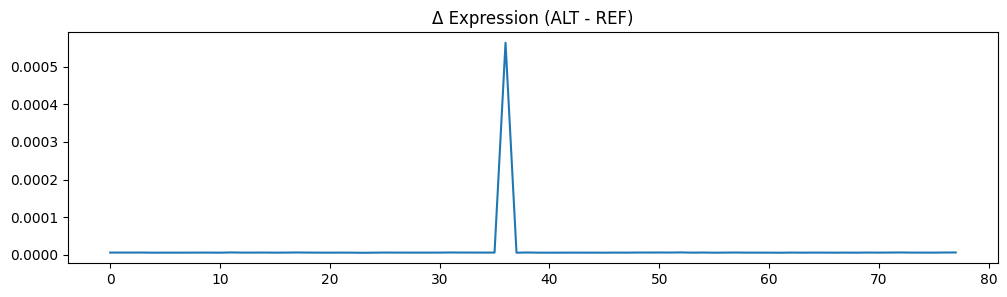

In [ ]:
model.eval()

# Generate a random DNA sequence
seq_len = 5000
dna = torch.randint(0, 4, (1, seq_len), device=device)

# Make a REF copy and an ALT copy
ref = dna.clone()
alt = dna.clone()

# Introduce a point mutation
pos = random.randint(500, seq_len-500)
ref_base = ref[0, pos].item()
alt_base = random.choice([b for b in [0,1,2,3] if b != ref_base])
alt[0, pos] = alt_base

cell_type = torch.tensor([2], device=device)

# REF vs ALT forward passes
with torch.no_grad():
    ref_ch, ref_sp, ref_ex = model(ref, cell_type)
    alt_ch, alt_sp, alt_ex = model(alt, cell_type)

# Compute Δ = ALT – REF
Δ_ch = (alt_ch - ref_ch).cpu().numpy().flatten()
Δ_ex = (alt_ex - ref_ex).cpu().numpy().flatten()

plt.figure(figsize=(12, 3))
plt.plot(Δ_ch)
plt.title("Cell Type - '2' Δ Chromatin Accessibility (ALT - REF)")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(Δ_ex)
plt.title("Δ Expression (ALT - REF)")
plt.show()
